In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
import torchvision
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import cv2

import pandas as pd
import shutil

### Dataloader

In [ ]:
class MyDataset(Dataset):
    def __init__(self, images_folder, masks_folder,
                 img_transform=None, masks_transform=None):
        super(Dataset, self).__init__()
        
        self.images_folder = images_folder
        self.masks_folder = masks_folder

        self.images_names = np.sort(os.listdir(images_folder))
        self.masks_names = np.sort(os.listdir(masks_folder))
        
        self.img_transform = img_transform
        self.masks_transform = masks_transform

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        item_image = Image.open(os.path.join(self.images_folder,
                                            self.images_names[idx])).convert('RGB')
        item_mask = Image.open(os.path.join(self.masks_folder,
                                              self.masks_names[idx])).convert('RGB')
        
        SEED = np.random.randint(123456789)
        if self.img_transform is not None:
            random.seed(SEED)
            item_image = self.img_transform(item_image)
        if self.masks_transform is not None:  
            random.seed(SEED)
            item_mask = self.masks_transform(item_mask)

        return item_image, item_mask

In [ ]:
# Put your prefix of data: dataset_med
# for example: '/content/drive/MyDrive/ML_project/dataset_med_noise_0'

# Choose noise: [0, 0.4, 0.8]

coef_noise = 0

prefix_dataset_normal = '/content/drive/MyDrive/ML_project/dataset_med_noise_0'
prefix_dataset_noise = '/content/drive/MyDrive/ML_project/dataset_med_noise_' + str(coef_noise)

In [ ]:
trans = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_set = MyDataset(images_folder = prefix_dataset_normal + '/train/images/', 
                      masks_folder = prefix_dataset_noise + '/train/masks',
                      img_transform = trans, masks_transform = trans)


val_set = MyDataset(images_folder = prefix_dataset_normal + '/val/images/', 
                      masks_folder = prefix_dataset_normal + '/val/masks',
                      img_transform = trans, masks_transform = trans)

In [ ]:
print(len(train_set.images_names))
print(len(train_set.masks_names))
print(len(val_set.images_names))
print(len(val_set.masks_names))

186
186
81
81


### Let's change the directory for needed files:

In [ ]:
cd /content/drive/MyDrive/ML_project 

/content/drive/MyDrive/ML_project


In [ ]:
image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size_train = 4
batch_size_val = batch_size_train

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 186, 'val': 81}

In [ ]:
# See example of images

import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

torch.Size([4, 3, 512, 512]) torch.Size([4, 3, 512, 512])
0.0 1.0 0.06723806 0.19605105
0.0 1.0 0.24234772 0.4285032


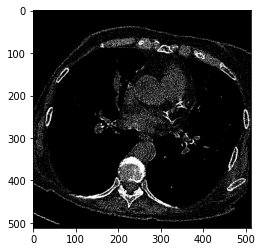

In [ ]:
plt.imshow(reverse_transform(inputs[0]))

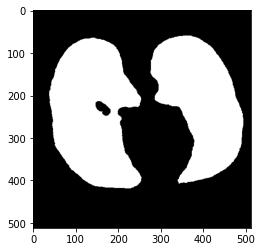

In [ ]:
plt.imshow(reverse_transform(masks[0]))

### Model

In [ ]:
import math
import copy
import Superloss
import loss_calculation
from loss_calculation import calc_loss
from train_with_loss import train_model_with_loss
from train_with_superloss import train_model_with_superloss
from collections import defaultdict
import torch.nn.functional as F  

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import unet
import helper
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = unet.UNet(num_class).to(device)

# Optimizer
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

cuda:0


## If we want to train with usual loss:

In [1]:
# 1)name_model:  
#     - 'Unet' 
#     - 'MiDaS'

# 2)regime:  
#     - 'mean' - per image
#     - 'none' - per pixel
#
# 3) weights:
#    - yes (want to save)
#    - no (don't want to save)
# 4) dataloaders - name of dataloaders
# 5) lam - lambda coef for superloss, default = 1


num_epochs = 30
name_model = 'Unet'
regime = 'none'  

model, loss_train, loss_val, accuracy_train, accuracy_val, iou_train, iou_val = \
train_model_with_loss(model = model,
                      model_name = name_model, 
                      regime = regime, 
                      weights = 'yes',
                      lam = 1, 
                      coef_noise = coef_noise, 
                      dataloaders = dataloaders,
                      device = device,
                      optimizer = optimizer_ft, 
                      scheduler = exp_lr_scheduler,
                      batch_size = batch_size_train, 
                      num_epochs = num_epochs)

# If train with usual loss:
df = pd.DataFrame(columns=['loss_train', 'loss_val', 'accuracy_train', 'accuracy_val', 'iou_train', 'iou_val'])

df['loss_train'] = loss_train
df['loss_val'] = loss_val

df['accuracy_train'] = accuracy_train
df['accuracy_val'] = accuracy_val

df['iou_train'] = iou_train
df['iou_val'] = iou_val

# Name of df file: 
#     - option: loss or superloss
#     - coef_noise: you initialized it earlier
if regime == 'mean':
  regime_name = 'image'
if regime == 'none':
  regime_name = 'pixel'

df.to_csv('./metrics_' + name_model + '_Brain_' + regime_name + '_loss_' + str(coef_noise) + '.csv', index=None)

## If we want to train with SUPERLOSS:

In [2]:

# 1)name_model:  
#     - 'Unet' 
#     - 'MiDaS'

# 2)regime:  
#     - 'mean' - per image
#     - 'none' - per pixel
#
# 3) weights:
#    - yes (want to save)
#    - no (don't want to save)
# 4) dataloaders - name of dataloaders
# 5) lam - lambda coef for superloss, [0.5, 1, 1.5]


num_epochs = 30
name_model = 'Unet'
regime = 'mean'
lam = 1

model, us_loss_train, us_loss_val, acc_train, acc_val, supp_loss_train, supp_loss_val, iou_train, iou_val = \
train_model_with_superloss(model = model, 
                           model_name = name_model, 
                           regime = regime, 
                           weights = 'yes', 
                           lam = lam, 
                           coef_noise = coef_noise,
                           dataloaders = dataloaders,
                           device = device,
                           optimizer = optimizer_ft, 
                           scheduler = exp_lr_scheduler,
                           batch_size = batch_size_train,
                           num_epochs = num_epochs)


# If train with SUPERLOSS:
df = pd.DataFrame(columns=['us_loss_train', 'us_loss_val', 'acc_train', 'acc_val', 'supp_loss_train', 'supp_loss_val', 'iou_train', 'iou_val'])

df['us_loss_train'] = us_loss_train
df['us_loss_val'] = us_loss_val

df['acc_train'] = acc_train
df['acc_val'] = acc_val

df['supp_loss_train'] = supp_loss_train
df['supp_loss_val'] = supp_loss_val

df['iou_train'] = iou_train
df['iou_val'] = iou_val

# Name of df file: 
#     - option: loss or superloss
#     - coef_noise: you initialized it earlier

if regime == 'mean':
  regime_name = 'image'
if regime == 'none':
  regime_name = 'pixel'

df.to_csv('./metrics_' + name_model + '_Brain_' + regime_name + '_superloss_' + str(coef_noise) + '_lam_' + str(lam) + '.csv', index=None)

In [ ]:
## Read data from csv    ############ SUPERLOSS #################

## example:
name_model = 'Unet'
regime_name = 'image'
coef_noise = 0
lam = 1

data = pd.read_csv('./metrics_' + name_model + '_Brain_' + regime_name + '_superloss_' + str(coef_noise) + '_lam_' + str(lam) + '.csv')

##### for superloss #########
us_loss_train = data['us_loss_train'].values
us_loss_val = data['us_loss_val'].values

acc_train = data['acc_train'].values
acc_val = data['acc_val'].values

supp_loss_train = data['supp_loss_train'].values
supp_loss_val = data['supp_loss_val'].values

iou_train_sl = data['iou_train'].values
iou_val_sl = data['iou_val'].values

In [ ]:
 ############ SUPERLOSS #################
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
ax1.plot(us_loss_train, label = 'train loss')
ax1.plot(us_loss_val,label = 'val loss')
ax1.set_title('Usual loss (with Superloss)')
ax1.legend()

ax2.plot(acc_train, label = 'DICE_train')
ax2.plot(acc_val,label = 'DICE_val')
ax2.set_title('DICE (with Superloss)')
ax2.legend()

ax3.plot(iou_train_sl, label = 'IOU_train')
ax3.plot(iou_val_sl,label = 'IOU_val')
ax3.set_title('IOU (with Superloss)')
ax3.legend()

ax4.plot(supp_loss_train,label = 'train super loss')
ax4.plot(supp_loss_val,label = 'val super loss')
ax4.set_title('Superloss')
ax4.legend()

In [ ]:
## Read data from csv    ############ LOSS #################

## example:
name_model = 'Unet'
regime_name = 'image'
# coef_noise = 0
lam = 1

data = pd.read_csv('./metrics_' + name_model + '_Brain_' + regime_name + '_loss_' + str(coef_noise) + '_lam_' + str(lam) + '.csv')

##### for loss #########
loss_train = data['loss_train'].values
loss_val = data['loss_val'].values

accuracy_train = data['accuracy_train'].values
accuracy_val = data['accuracy_val'].values

iou_train_l = data['iou_train'].values
iou_val_l = data['iou_val'].values

In [ ]:
############ LOSS #################

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(loss_train, label = 'train loss')
ax1.plot(loss_val,label = 'val loss')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(accuracy_train, label = 'DICE_train')
ax2.plot(accuracy_val,label = 'DICE_val')
ax2.set_title('DICE')
ax2.legend()

ax3.plot(iou_train_l, label = 'IOU_train')
ax3.plot(iou_val_l,label = 'IOU_val')
ax3.set_title('IOU')
ax3.legend()

In [ ]:
######## COMPARISON OF LOSS AND SUPERLOSS ############

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(us_loss_val, label = 'SL')
ax1.plot(loss_val,label = 'L')
ax1.set_title('Usual loss')
ax1.legend()

ax2.plot(acc_val, label = 'SL')
ax2.plot(accuracy_val,label = 'L')
ax2.set_title('DICE')
ax2.legend()

ax3.plot(iou_val_sl, label = 'SL')
ax3.plot(iou_val_l,label = 'L')
ax3.set_title('IOU')
ax3.legend()

In [3]:
# prediction

import math
import helper
from helper import plot_side_by_side

model.eval()   

val_batch = torch.utils.data.DataLoader(val_set,
                                            batch_size=3,
                                            shuffle=True)
        
inputs, labels = next(iter(val_batch))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])